# 01 — Exploratory Data Analysis (EPL 2019‑2025)

This notebook loads the **processed** dataset created by the ETL pipeline (`data/processed/merged.parquet`) and provides a concise exploratory overview:

1. Basic shape & schema  
2. Descriptive statistics  
3. Goal distributions  
4. Expected‑goals (xG) distributions  
5. xG vs. actual goal difference scatter  
6. Bookmaker implied probabilities  
7. Class balance for match outcome target  
8. Correlation heat‑map
9. Season‑by‑season analysis (average goals & xG)
10. Team‑level aggregates (total xG & goals, 2019‑2025)

In [1]:
%pip install -q fastparquet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path("../data/processed/merged.parquet")
assert DATA_PATH.exists(), f"{DATA_PATH} not found. Run merge pipeline first."

df = pd.read_parquet(DATA_PATH)
print(f"Shape: {df.shape}")
df.head()

Shape: (8955, 16)


,date,home_team,away_team,home_goals,away_goals,bookie_home,bookie_draw,bookie_away,league,xG_home,xG_away,bookie_sum,bookie_prob_home,bookie_prob_draw,bookie_prob_away,result
0,2019-08-16,Bayern Munich,Hertha,2,2,1.14,8.00,15.00,BUNDESLIGA,NaN,NaN,1.068860,0.820681,0.116947,0.062372,D
1,2019-08-17,Dortmund,Augsburg,5,1,1.20,7.00,13.00,BUNDESLIGA,NaN,NaN,1.053114,0.791304,0.135652,0.073043,H
2,2019-08-17,Freiburg,Mainz,3,0,2.25,3.25,3.40,BUNDESLIGA,NaN,NaN,1.046254,0.424796,0.294089,0.281115,H
3,2019-08-17,Leverkusen,Paderborn,3,2,1.25,6.00,12.00,BUNDESLIGA,NaN,NaN,1.050000,0.761905,0.158730,0.079365,H
4,2019-08-17,Werder Bremen,Fortuna Dusseldorf,1,3,1.75,3.75,4.75,BUNDESLIGA,NaN,NaN,1.048622,0.544933,0.254302,0.200765,A


In [2]:
df.info()
df.describe().T.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8955 entries, 0 to 8954
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              8955 non-null   datetime64[ns]
 1   home_team         8955 non-null   object        
 2   away_team         8955 non-null   object        
 3   home_goals        8955 non-null   int64         
 4   away_goals        8955 non-null   int64         
 5   bookie_home       8950 non-null   float64       
 6   bookie_draw       8950 non-null   float64       
 7   bookie_away       8950 non-null   float64       
 8   league            8955 non-null   object        
 9   xG_home           5793 non-null   float64       
 10  xG_away           5793 non-null   float64       
 11  bookie_sum        8950 non-null   float64       
 12  bookie_prob_home  8950 non-null   float64       
 13  bookie_prob_draw  8950 non-null   float64       
 14  bookie_prob_away  8950 n

,count,mean,min,25%,50%,75%,max,std
date,8955,2022-01-13 20:29:01.507537664,2019-08-09 00:00:00,2020-12-06 00:00:00,2022-01-08 00:00:00,2023-04-02 00:00:00,2024-06-02 00:00:00,NaN
home_goals,8955.0,1.54316,0.0,1.0,1.0,2.0,9.0,1.307359
away_goals,8955.0,1.267225,0.0,0.0,1.0,2.0,9.0,1.174402
bookie_home,8950.0,2.778377,1.05,1.67,2.25,3.2,23.0,1.817836
bookie_draw,8950.0,4.054657,2.0,3.4,3.6,4.2,17.0,1.198997


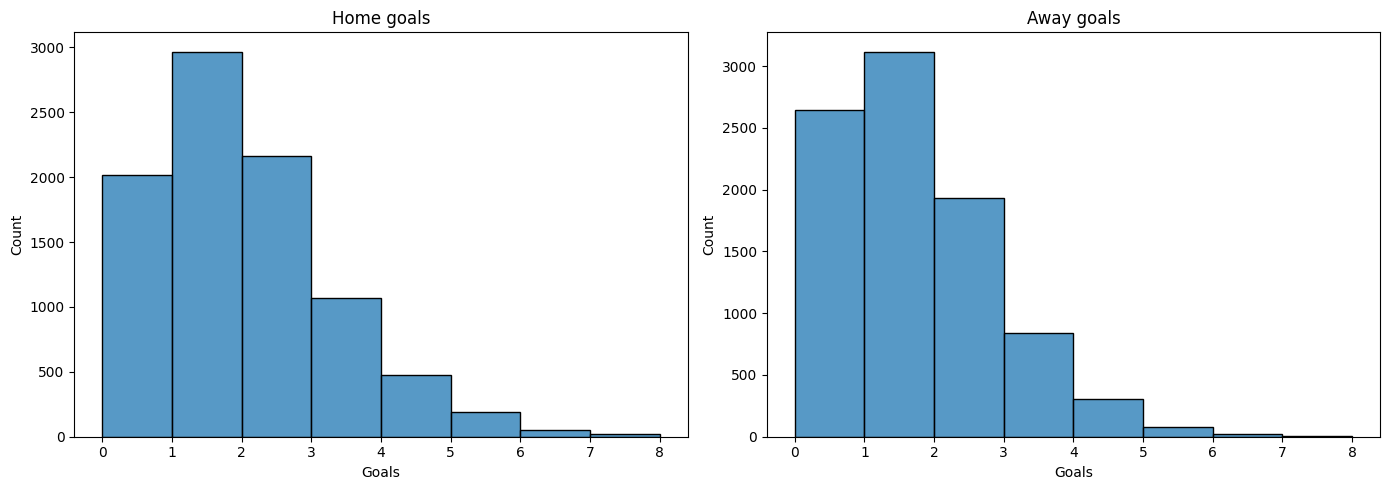

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['home_goals'], bins=range(0, 9), ax=ax[0])
ax[0].set(title='Home goals', xlabel='Goals')
sns.histplot(df['away_goals'], bins=range(0, 9), ax=ax[1])
ax[1].set(title='Away goals', xlabel='Goals')
plt.tight_layout()
plt.show()

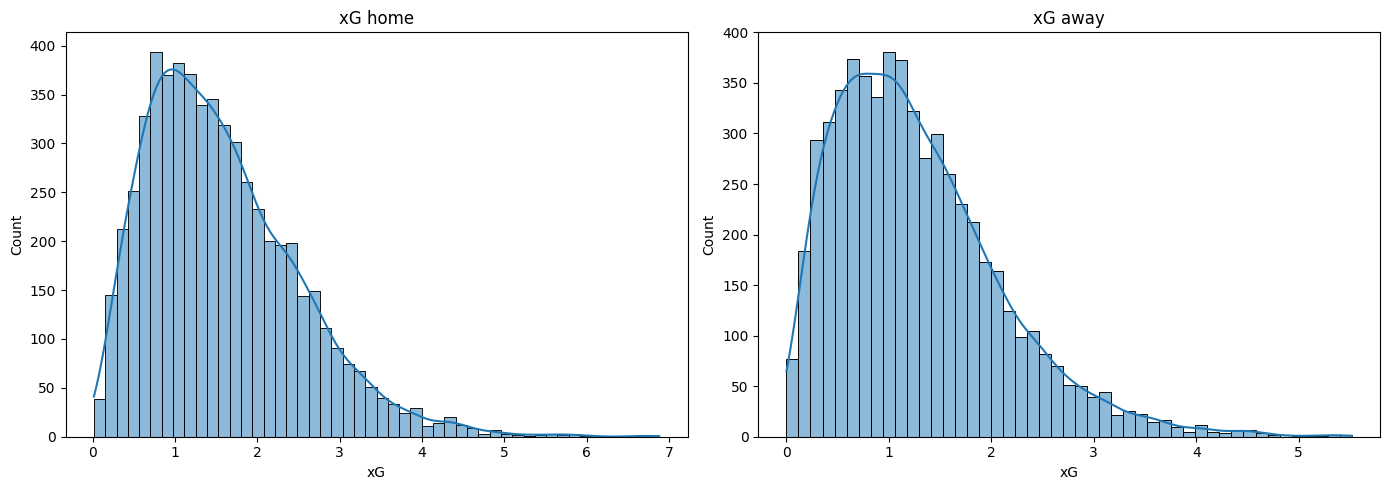

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['xG_home'], kde=True, ax=ax[0])
ax[0].set(title='xG home', xlabel='xG')
sns.histplot(df['xG_away'], kde=True, ax=ax[1])
ax[1].set(title='xG away', xlabel='xG')
plt.tight_layout()
plt.show()

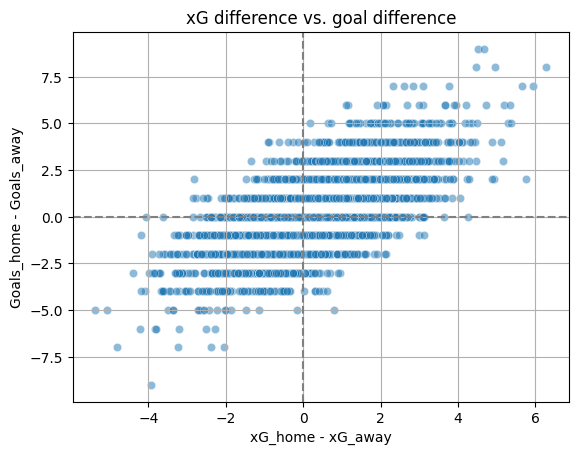

In [5]:
df['xg_diff'] = df['xG_home'] - df['xG_away']
df['goal_diff'] = df['home_goals'] - df['away_goals']

sns.scatterplot(data=df, x='xg_diff', y='goal_diff', alpha=0.5)
plt.axhline(0, ls='--', c='grey')
plt.axvline(0, ls='--', c='grey')
plt.title('xG difference vs. goal difference')
plt.xlabel('xG_home - xG_away')
plt.ylabel('Goals_home - Goals_away')
plt.grid(True)
plt.show()

In [6]:
# already computed in merge pipeline; recalc defensive
df['bookie_sum'] = 1/df['bookie_home'] + 1/df['bookie_draw'] + 1/df['bookie_away']
df['bookie_prob_home'] = (1/df['bookie_home']) / df['bookie_sum']
df['bookie_prob_draw'] = (1/df['bookie_draw']) / df['bookie_sum']
df['bookie_prob_away'] = (1/df['bookie_away']) / df['bookie_sum']

df[['bookie_prob_home','bookie_prob_draw','bookie_prob_away']].describe()

,bookie_prob_home,bookie_prob_draw,bookie_prob_away
count,8950.000000,8950.000000,8950.000000
mean,0.435957,0.247110,0.316933
std,0.181765,0.048051,0.166057
min,0.041212,0.056031,0.027781
25%,0.299323,0.223375,0.189505
50%,0.422853,0.261482,0.291441
75%,0.567021,0.279829,0.421053
max,0.899562,0.448204,0.885873


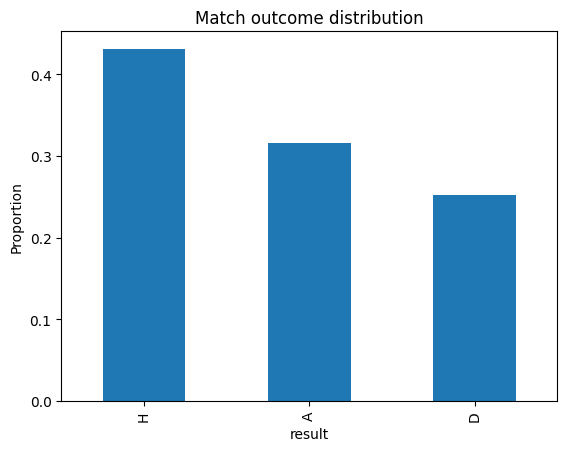

In [7]:
df['result'].value_counts(normalize=True).plot(kind='bar', title='Match outcome distribution')
plt.ylabel('Proportion')
plt.show()

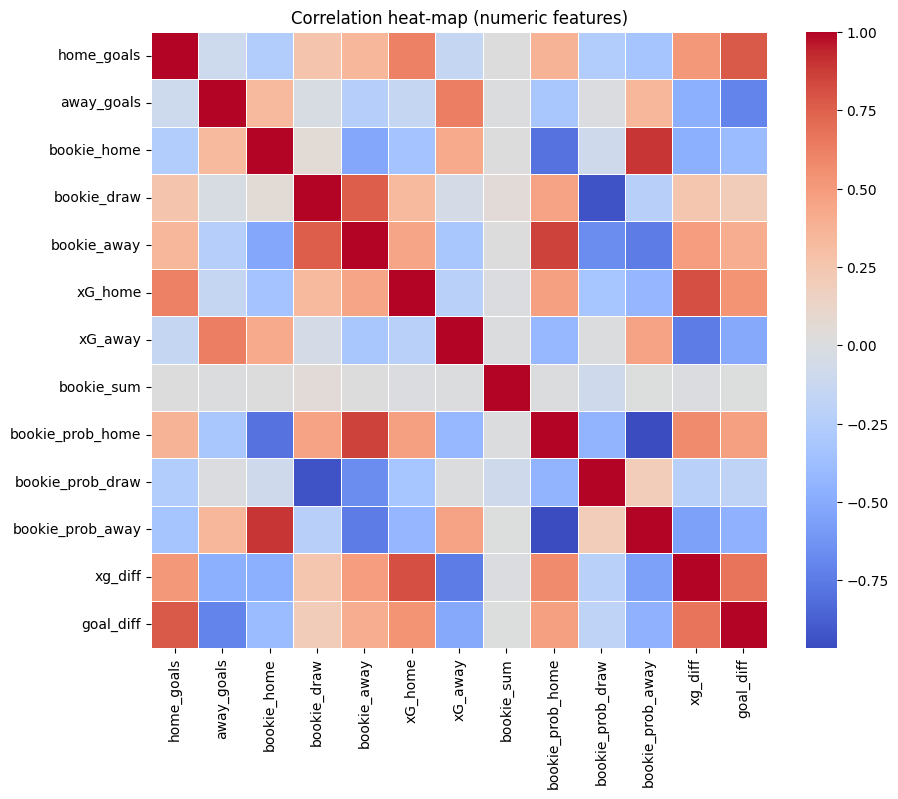

In [8]:
import numpy as np

numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', annot=False, square=True, linewidths=.5)
plt.title('Correlation heat‑map (numeric features)')
plt.show()

In [9]:
if 'season' not in df.columns:
    df['season'] = df['date'].dt.year
season_stats = (df.groupby('season')
                  .agg(avg_goals_home=('home_goals','mean'),
                       avg_goals_away=('away_goals','mean'),
                       avg_xg_home=('xG_home','mean'),
                       avg_xg_away=('xG_away','mean'))
                  .reset_index())
season_stats


,season,avg_goals_home,avg_goals_away,avg_xg_home,avg_xg_away
0,2019,1.565315,1.224099,1.554511,1.248986
1,2020,1.490446,1.322293,1.466273,1.298459
2,2021,1.532696,1.279678,1.497402,1.265032
3,2022,1.542604,1.249704,1.572698,1.293080
4,2023,1.571652,1.195414,1.634402,1.251648
5,2024,1.576667,1.372222,1.744663,1.324189


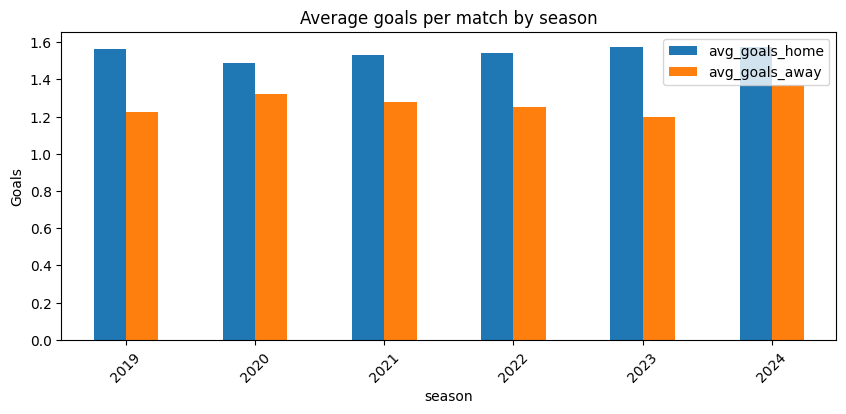

In [10]:
season_stats.set_index('season')[['avg_goals_home','avg_goals_away']].plot(kind='bar', figsize=(10,4))
plt.title('Average goals per match by season')
plt.ylabel('Goals')
plt.xticks(rotation=45)
plt.show()

In [12]:
team_stats = (df.groupby('home_team')
                 .agg(total_goals_home=('home_goals','sum'),
                      total_xg_home=('xG_home','sum'))
                 .sort_values('total_goals_home', ascending=False)
                 .head(15))
team_stats

,total_goals_home,total_xg_home
home_team,,
Bayern Munich,271,117.051111
Man City,269,224.827684
Dortmund,230,0.000000
Liverpool,225,223.997825
Paris SG,224,0.000000
Inter,222,196.279059
Barcelona,213,143.725349
Atalanta,211,182.468514
Real Madrid,209,132.929601


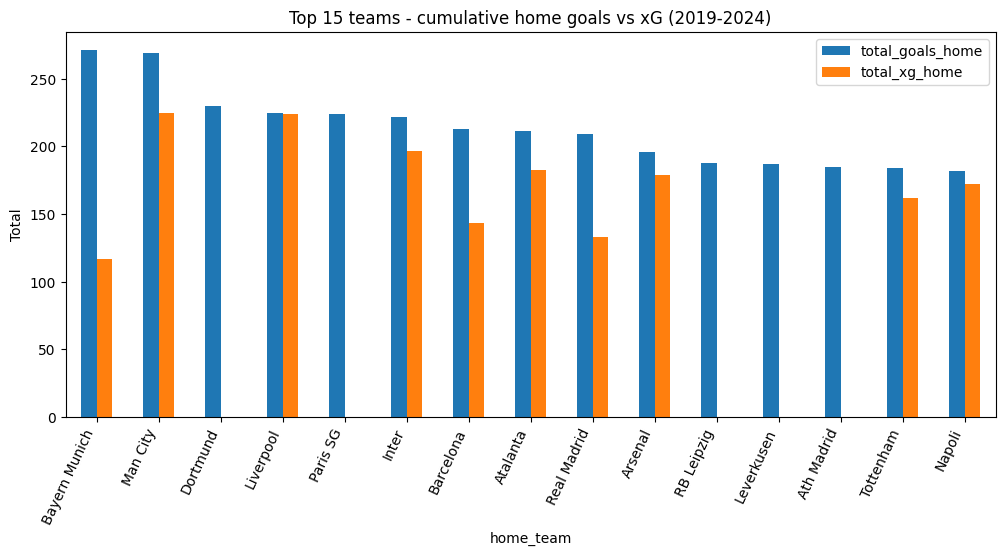

In [13]:
team_stats[['total_goals_home','total_xg_home']].plot(kind='bar', figsize=(12,5))
plt.title('Top 15 teams - cumulative home goals vs xG (2019‑2024)')
plt.ylabel('Total')
plt.xticks(rotation=65, ha='right')
plt.show()